In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Colab_Notebooks

/content/drive/MyDrive/Colab_Notebooks


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
import random
import gc
import pickle
from collections import defaultdict

import torch
import torchvision.transforms.functional as F

In [5]:
class preprocessing():
    def __init__(self):
        self.default_path = os.getcwd()
        self.train_source_df = pd.read_csv(os.path.join(self.default_path, "train_source.csv"))
        self.train_target_df = pd.read_csv(os.path.join(self.default_path, "train_target.csv"))
        self.val_source_df = pd.read_csv(os.path.join(self.default_path, "val_source.csv"))
        self.test_df = pd.read_csv(os.path.join(self.default_path, "test.csv"))
        self.submission = pd.read_csv(os.path.join(self.default_path, "sample_submission.csv"))

        self.dfs = [self.train_source_df, self.train_target_df, self.val_source_df, self.test_df]
        self.df_names = ["train_source", "train_target", "validation_source", "test"]

        load_count = 200
        image_size = (200, 200)
        self.all_train_source_images = []
        self.all_train_source_masks = []
        for i in tqdm(range(load_count)):
            random_sample = random.randint(0, self.train_source_df.shape[0]-1)
            self.all_train_source_images.append(cv2.resize(cv2.imread(self.train_source_df.loc[random_sample, "img_path"])[:, :, ::-1], image_size))
            self.all_train_source_masks.append(cv2.resize(cv2.imread(self.train_source_df.loc[random_sample, "gt_path"])[:, :, ::-1], image_size))
        self.all_train_source_images = np.stack(self.all_train_source_images, axis=0)
        self.all_train_source_masks = np.stack(self.all_train_source_masks, axis=0)

        self.all_train_target_images = []
        for i in tqdm(range(load_count)):
            random_sample = random.randint(0, self.train_target_df.shape[0]-1)
            self.all_train_target_images.append(cv2.resize(cv2.imread(self.train_target_df.loc[random_sample, "img_path"])[:, :, ::-1], image_size))
        self.all_train_target_images = np.stack(self.all_train_target_images, axis=0)

        self.all_val_source_images = []
        self.all_val_source_masks = []
        for i in tqdm(range(load_count)):
            random_sample = random.randint(0, self.val_source_df.shape[0]-1)
            self.all_val_source_images.append(cv2.resize(cv2.imread(self.val_source_df.loc[random_sample, "img_path"])[:, :, ::-1], image_size))
            self.all_val_source_masks.append(cv2.resize(cv2.imread(self.val_source_df.loc[random_sample, "gt_path"])[:, :, ::-1], image_size))
        self.all_val_source_images = np.stack(self.all_val_source_images, axis=0)
        self.all_val_source_masks = np.stack(self.all_val_source_masks, axis=0)


        self.all_test_images = []
        for i in tqdm(range(load_count)):
            random_sample = random.randint(0, self.test_df.shape[0]-1)
            self.all_test_images.append(cv2.resize(cv2.imread(self.test_df.loc[random_sample, "img_path"])[:, :, ::-1], image_size))
        self.all_test_images = np.stack(self.all_test_images, axis=0)



    def check_train_data(self):
        for (df, name) in zip(self.dfs, self.df_names):
            print(f"{name}_head :\n {df.head()}")
            print(f"{name}_info :\n")
            print(df.info())
            print(f"{name}_describe :\n {df.describe()}")
            print(f"{name}_na_count : {df.isna().sum().sum()}")


In [37]:
pp.submission.head()

id  mask_rle
0  TEST_0000_class_0        -1
1  TEST_0000_class_1        -1
2  TEST_0000_class_2        -1
3  TEST_0000_class_3        -1
4  TEST_0000_class_4        -1

In [6]:
pp = preprocessing()
pp.check_train_data()

100%|██████████| 200/200 [05:10<00:00,  1.55s/it]

train_source_head :
                   id                                    img_path  \
0  TRAIN_SOURCE_0000  ./train_source_image/TRAIN_SOURCE_0000.png   
1  TRAIN_SOURCE_0001  ./train_source_image/TRAIN_SOURCE_0001.png   
2  TRAIN_SOURCE_0002  ./train_source_image/TRAIN_SOURCE_0002.png   
3  TRAIN_SOURCE_0003  ./train_source_image/TRAIN_SOURCE_0003.png   
4  TRAIN_SOURCE_0004  ./train_source_image/TRAIN_SOURCE_0004.png   

                                   gt_path  
0  ./train_source_gt/TRAIN_SOURCE_0000.png  
1  ./train_source_gt/TRAIN_SOURCE_0001.png  
2  ./train_source_gt/TRAIN_SOURCE_0002.png  
3  ./train_source_gt/TRAIN_SOURCE_0003.png  
4  ./train_source_gt/TRAIN_SOURCE_0004.png  
train_source_info :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2194 entries, 0 to 2193
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        2194 non-null   object
 1   img_path  2194 non-null   object
 2   gt_path   2194 n

In [7]:
with open("pp_image_loded.pickle", "wb") as f:
    pickle.dump(pp, f)

In [ ]:
with open("pp_image_loded.pickle", "rb") as f:
    pp = pickle.load(f)

In [41]:
pp.test_df.head()

id                    img_path
0  TEST_0000  ./test_image/TEST_0000.png
1  TEST_0001  ./test_image/TEST_0001.png
2  TEST_0002  ./test_image/TEST_0002.png
3  TEST_0003  ./test_image/TEST_0003.png
4  TEST_0004  ./test_image/TEST_0004.png

In [8]:
def show_image_and_mask(df, count):
    random_numbers = np.random.randint(0, df.shape[0]-1, count)

    if df.shape[1] == 3:
        fig, axes = plt.subplots(count, 2, figsize=(16, 16))
        for i in range(count):
            img = cv2.imread(df.loc[random_numbers[i], "img_path"])[:, :, ::-1]
            mask = np.clip(cv2.imread(df.loc[random_numbers[i], "gt_path"])[:, :, ::-1] * 255.0 / 12., 1.0, 254.0)
            mask = mask.astype(int)
            axes[i][0].set_title("image")
            axes[i][1].set_title("mask")
            axes[i][0].axis('off')
            axes[i][1].axis('off')
            axes[i][0].imshow(img)
            axes[i][1].imshow(mask)
    else:
        fig, axes = plt.subplots(count // 2, 2, figsize=(16, 9))
        for i in range(count):
            axes[i // 2][i % 2].axis('off')
            axes[i // 2][i % 2].imshow(img)

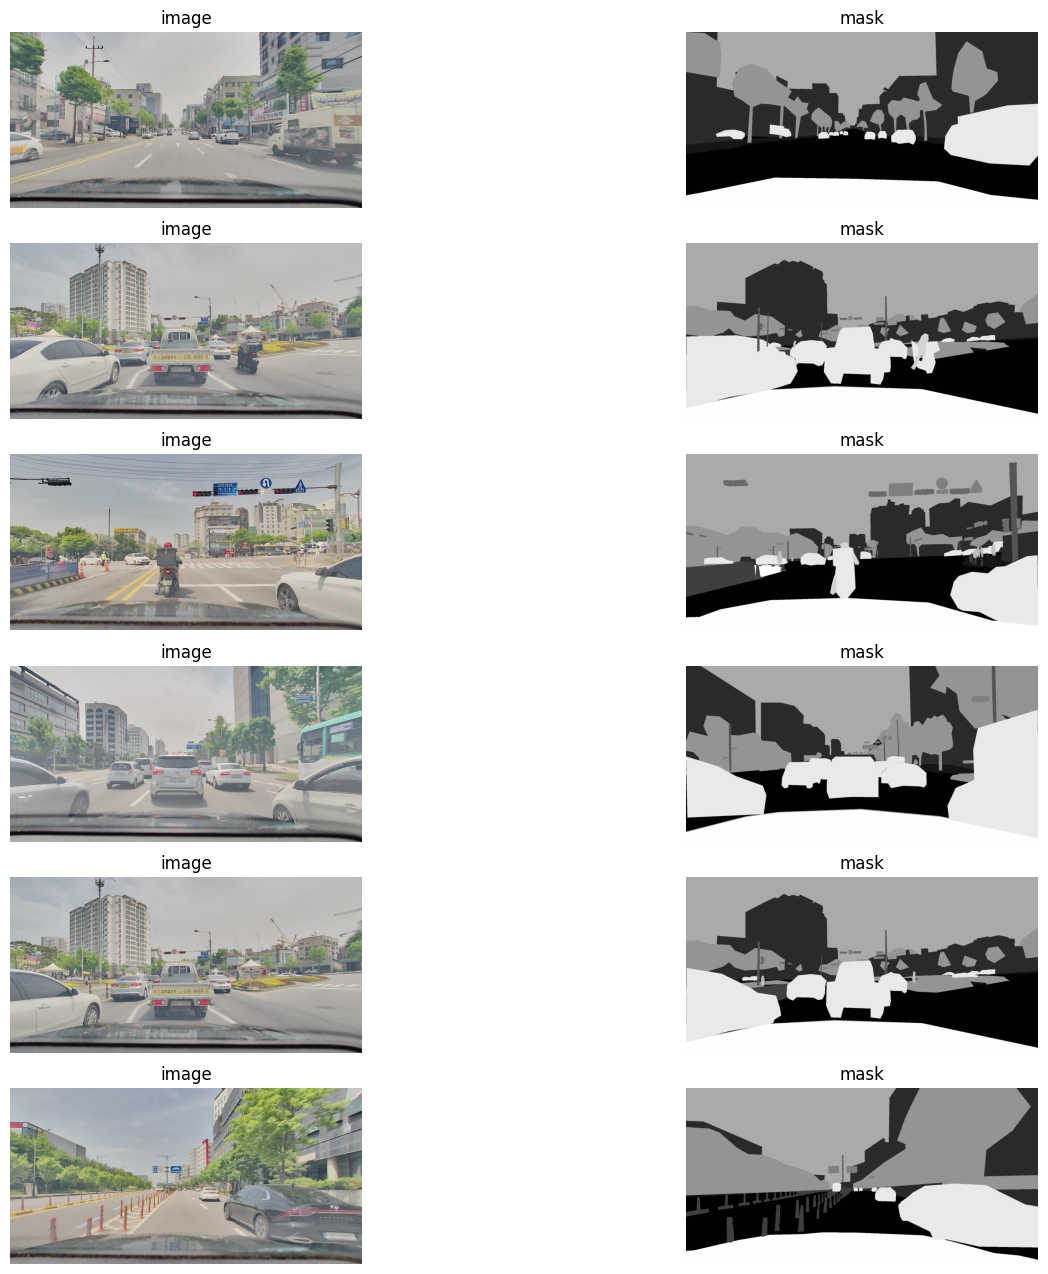

In [9]:
show_image_and_mask(pp.train_source_df, 6)

In [26]:
# show_image_and_mask(pp.train_source_df, 2)
# for i in tqdm(range(100)):
#     mask = cv2.imread(pp.train_source_df.loc[i, "gt_path"])[:, :, ::-1]
#     for h in mask:
#         for w in h:
#             if (w[0] != w[1]) or (w[1] != w[2]):
#                 print("not same!")
#                 break

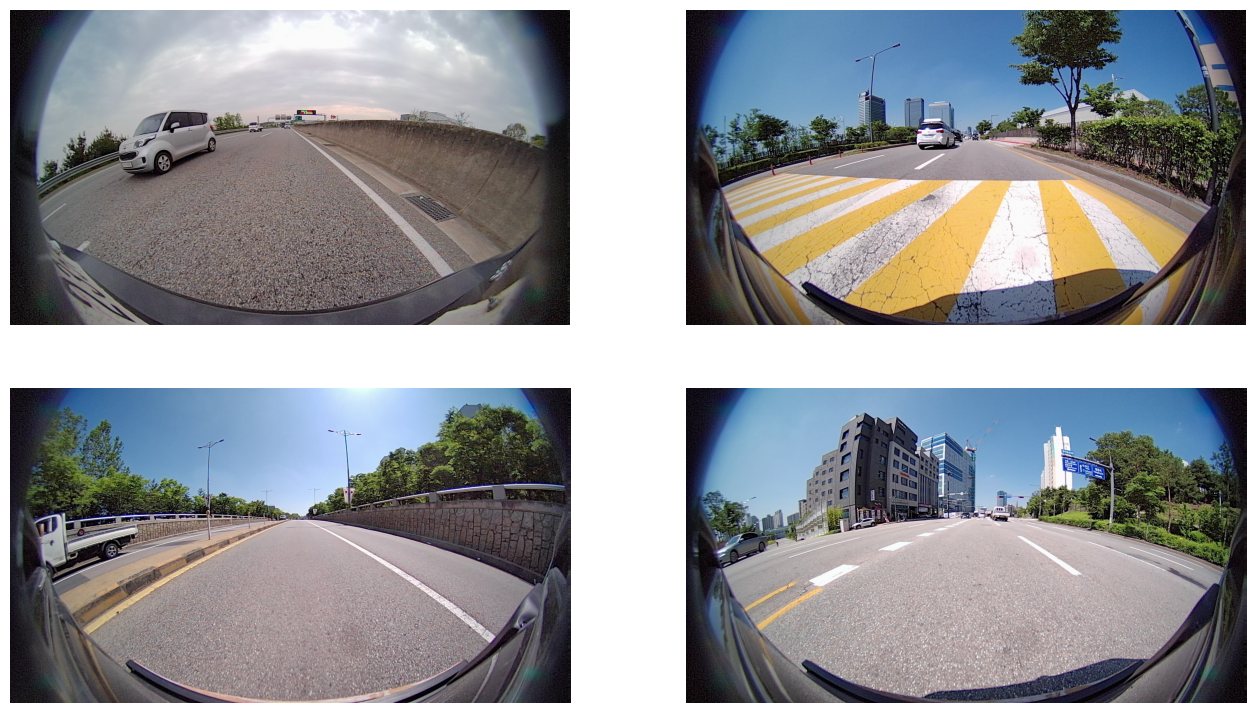

In [81]:
show_image_and_mask(pp.train_target_df, 4)

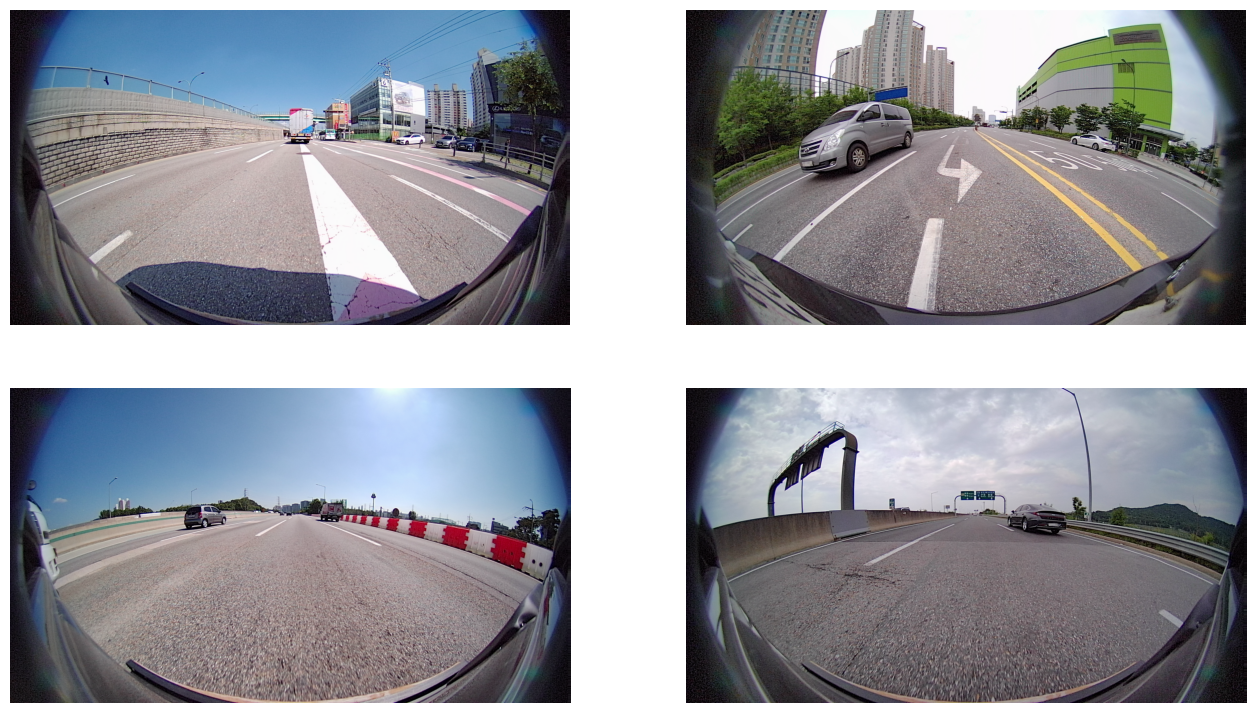

In [82]:
show_image_and_mask(pp.test_df, 4)

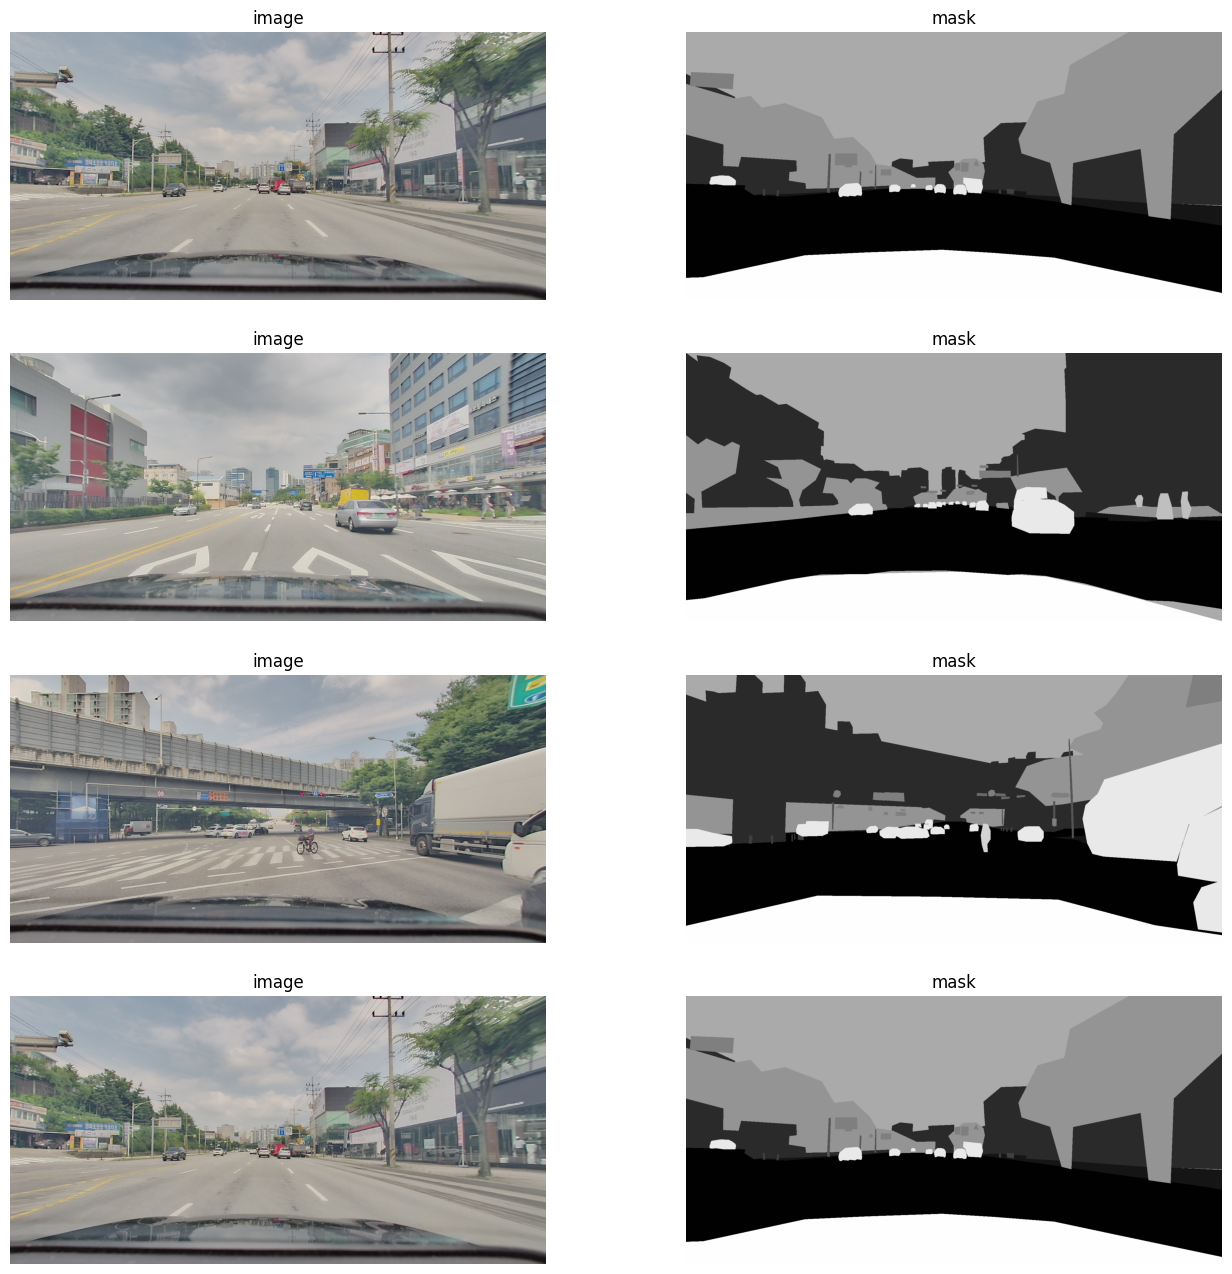

In [10]:
show_image_and_mask(pp.val_source_df, 4)

# 색상 채널 분석
- ground truth에 대한 마스킹이 차체(흰색) - 배경(검은색)으로 나뉘어 있음 -> 채널 값의 비교를 통해 배경이 얼마나 큰 비중을 차지하는지 확인해보기
- 이미지 자체에 대해서 주로 낮에 찍혔는지, 밤에 찍혔는지 확인

In [11]:
classes = ["Road", "Sidewalk", "Construction", "Fence", "Pole", \
           "Traffic Light", "Traffic Sign", "Nature", "Sky", "Person", "Rider", "Car"]

class_mapping = dict((i, cl) for (i, cl) in enumerate(classes))
class_mapping[255] = "background"
class_mapping

{0: 'Road',
 1: 'Sidewalk',
 2: 'Construction',
 3: 'Fence',
 4: 'Pole',
 5: 'Traffic Light',
 6: 'Traffic Sign',
 7: 'Nature',
 8: 'Sky',
 9: 'Person',
 10: 'Rider',
 11: 'Car',
 255: 'background'}

In [11]:
pp.all_train_source_masks[0].shape

(200, 200, 3)

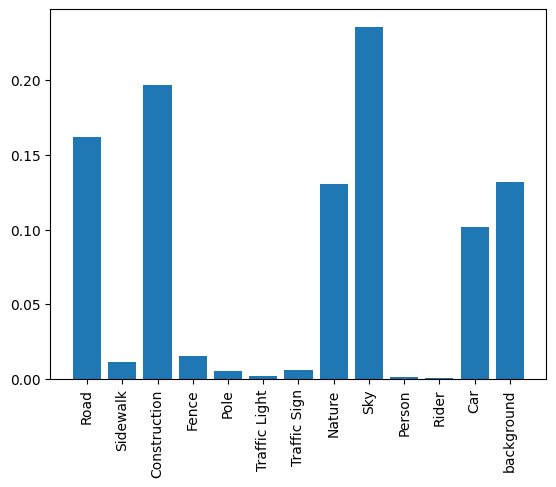

In [13]:
def get_mask_info(masks):
    d = {}
    unique, counts = np.unique(masks, return_counts=True)
    unique = [class_mapping[i] for i in unique]
    counts = counts / sum(counts)

    fig, ax = plt.subplots()
    plt.xticks(rotation=90)
    ax.bar(unique, counts)
    plt.show()

get_mask_info(pp.all_train_source_masks)

mean_all_pixel_value : 151.355362375 pixel_std : 40.89401351103564 max : 255 min : 0
RED CHANNEL mean : 151.961220125         std : 42.189037171951384 max : 255, min : 0
GREEN CHANNEL mean : 153.0865125         std : 39.8953317048166 max : 255, min : 0
BLUE CHANNEL mean : 149.0183545         std : 40.45470459183122 max : 255, min : 0


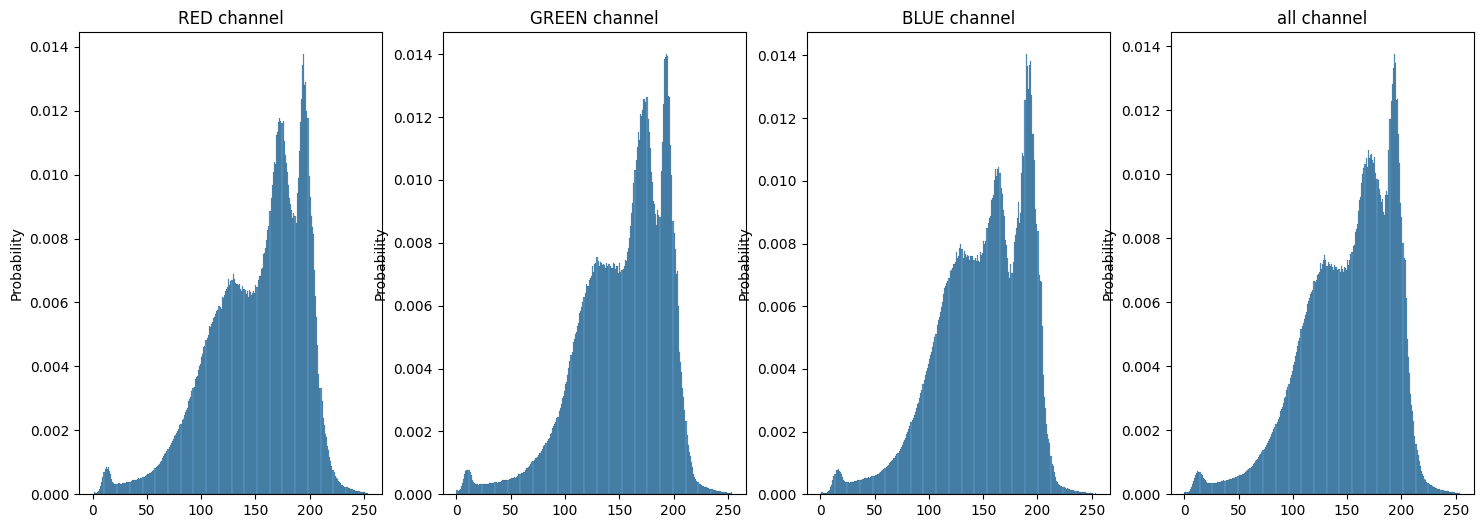

In [7]:
def get_image_info(images):
    # images : numpy_array with shape (num_images, height, width, channel)
    channel_name = ["RED", "GREEN", "BLUE"]
    print(f"mean_all_pixel_value : {np.mean(images)} pixel_std : {np.std(images)} max : {images.max()} min : {images.min()}")
    for i in range(3):
        print(f"{channel_name[i]} CHANNEL mean : {np.mean(images[:, :, :, i])} \
        std : {np.std(images[:, :, :, i])} max : {images[:, :, :, i].max()}, min : {images[:, :, :, i].min()}")

    fig, axes = plt.subplots(1,4, figsize=(18,6))
    for i, ax in enumerate(axes):
        if i == 3:
            df = images.ravel()
            ax.set_title("all channel")
        else:
            df = images[:, :, :, i].ravel()
            ax.set_title(channel_name[i]+' channel')
        sns.histplot(df, bins=np.arange(0,255), stat="probability", ax=ax)

    plt.show()


get_image_info(pp.all_train_source_images)

mean_all_pixel_value : 145.09070733333334 pixel_std : 41.579286673330635 max : 255 min : 0
RED CHANNEL mean : 145.05601725         std : 43.54248401639142 max : 255, min : 0
GREEN CHANNEL mean : 146.563211875         std : 40.42788695948453 max : 255, min : 0
BLUE CHANNEL mean : 143.652892875         std : 40.643726441097584 max : 255, min : 0


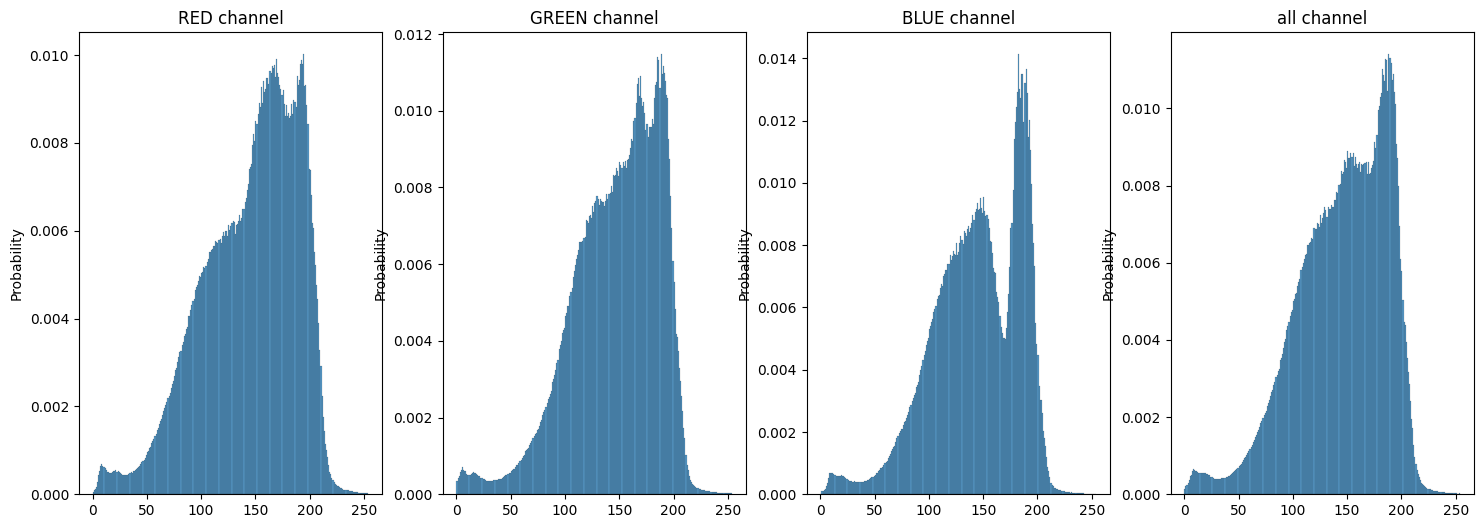

In [8]:
get_image_info(pp.all_val_source_images)

mean_all_pixel_value : 120.60349091666667 pixel_std : 63.102020384032365 max : 255 min : 0
RED CHANNEL mean : 120.408038375         std : 61.87758840694689 max : 255, min : 0
GREEN CHANNEL mean : 118.420493125         std : 62.3303122838866 max : 255, min : 0
BLUE CHANNEL mean : 122.98194125         std : 64.97099696119453 max : 255, min : 0


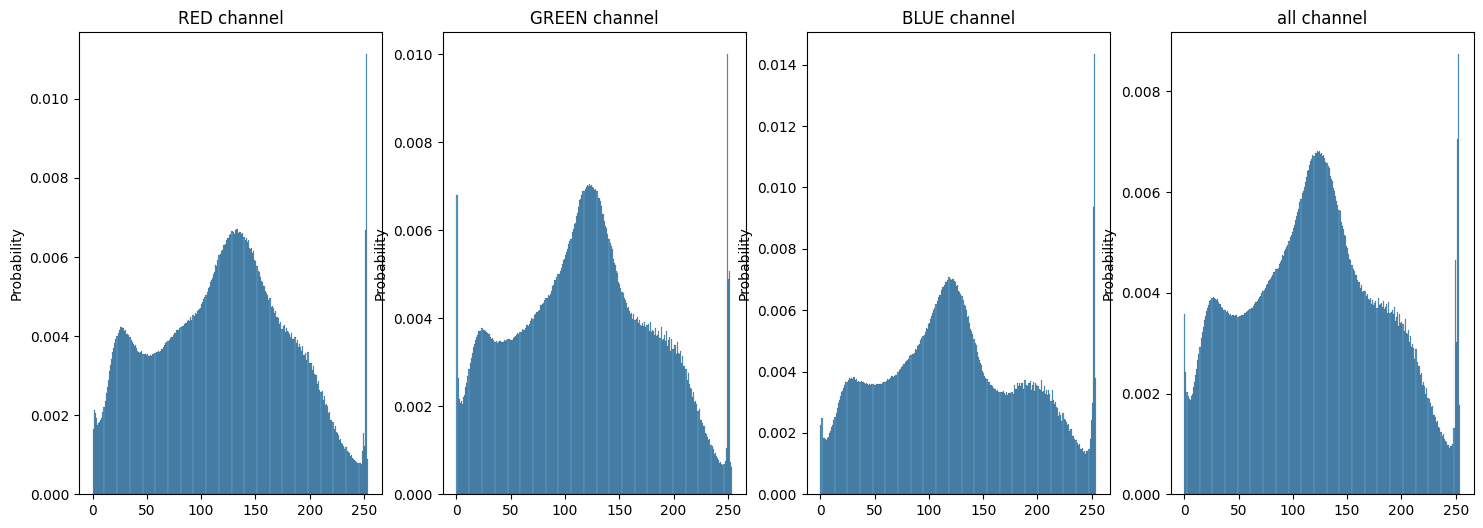

In [9]:
get_image_info(pp.all_test_images)

mean_all_pixel_value : 123.017733 pixel_std : 62.108307503564994 max : 255 min : 0
RED CHANNEL mean : 120.347601625         std : 60.728406806331606 max : 255, min : 0
GREEN CHANNEL mean : 120.76276525         std : 60.98457260999205 max : 255, min : 0
BLUE CHANNEL mean : 127.942832125         std : 64.25571578240391 max : 255, min : 0


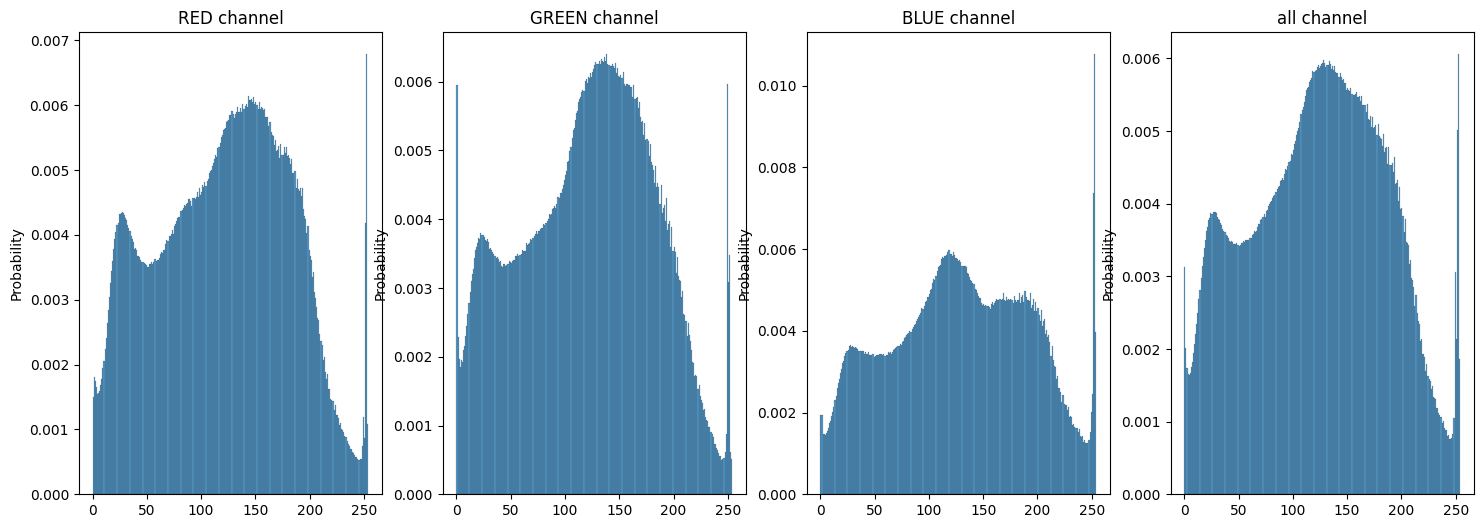

In [10]:
get_image_info(pp.all_train_target_images)

In [ ]:
fig, axes = plt.subplots(10, 1)
for i in range(10)
    print(axes[i][0])